In [3]:
import os
import pickle

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    TOML_PATH,
    DATA_PATH,
    BUILD_DIR,
)



In [4]:
src = os.path.join(BUILD_DIR, "inference.pkl")
with open(src, "rb") as f:
    COMBINED_COMBINATIONS, COMBINED_POSTERIOR_SAMPLES = pickle.load(f)

DATA = pd.read_csv(DATA_PATH)
print(DATA.shape)

config = Config(TOML_PATH)
model = NonHierarchicalBayesianModel(config)


(3572, 46)


In [5]:
df = DATA.copy()

positions_charges = (
    DATA[["compound_position", "compound_charge_params"]]
    .apply(tuple, axis=1)
    .unique()
    .tolist()
)
positions_charges = list(set(positions_charges))
positions_charges = sorted(positions_charges)


In [6]:
positions_charges

[('-C6LC', '20-0-80-25'),
 ('-C6LC', '50-0-50-100'),
 ('C6LC-', '20-0-80-25'),
 ('C6LC-', '50-0-50-100'),
 ('C6LC-C6LX', '20-0-80-25'),
 ('C6LC-C6LX', '50-0-50-100'),
 ('C6LX-C6LC', '20-0-80-25'),
 ('C6LX-C6LC', '50-0-50-100')]

In [7]:
combinations = COMBINED_COMBINATIONS
posterior_samples = COMBINED_POSTERIOR_SAMPLES


In [8]:
subjects = sorted(DATA["participant"].unique().tolist())

a = None
a_mask = None

for subject in subjects:
    for position, charge in positions_charges:
        curr_combination = (subject, position, charge)
        if curr_combination in combinations:
            ind = [c == curr_combination for c in combinations]
            assert sum(ind) == 1
            if a is None:
                a = posterior_samples[site.a][:, ind, ...]
                a_mask = np.full(a.shape, False)
            else:
                a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
                a_mask = np.concatenate(
                    [
                        a_mask,
                        np.full(
                            (
                                posterior_samples[site.a].shape[0],
                                1,
                                posterior_samples[site.a].shape[-1]
                            ),
                            False
                        )
                    ],
                    axis=1
                )
        else:
            if a is None:
                a = np.zeros((
                    posterior_samples[site.a].shape[0],
                    1,
                    posterior_samples[site.a].shape[-1]
                ))
                a_mask = np.full(a.shape, True)
            else:
                a = np.concatenate(
                    [
                        a,
                        np.zeros((
                            posterior_samples[site.a].shape[0],
                            1,
                            posterior_samples[site.a].shape[-1]
                        ))
                    ],
                    axis=1
                )
                a_mask = np.concatenate(
                    [
                        a_mask,
                        np.full(
                            (
                                posterior_samples[site.a].shape[0],
                                1,
                                posterior_samples[site.a].shape[-1],
                            ),
                            True
                        ),
                    ],
                    axis=1
                )


a = a.reshape(
    -1, len(subjects), len(positions_charges), *a.shape[2:]
)
a_mask = a_mask.reshape(
    -1, len(subjects), len(positions_charges), *a_mask.shape[2:]
)

a = ma.masked_array(a, mask=a_mask)
a.shape


(4000, 8, 8, 6)

In [9]:
arr = []
arr_labels = []

for l, (l_position, l_charge) in enumerate(positions_charges):
    label = f"{l_position}\n{l_charge}"
    arr_labels.append(label)

    for r, (r_position, r_charge) in enumerate(positions_charges):
        if l == r:
            arr.append(1)
            continue

        l_samples = a[:, :, l, ...].mean(axis=0)
        r_samples = a[:, :, r, ...].mean(axis=0)
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
        arr.append(pvalue)

arr = np.array(arr)
arr = arr.reshape(-1, len(arr_labels))
arr_mask = np.diag(arr)


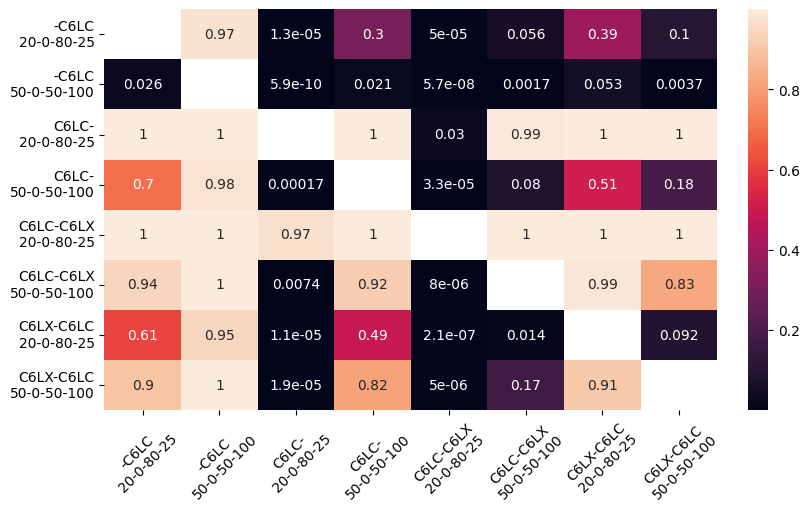

In [10]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 8, nrows * 5),
    constrained_layout=True,
    squeeze=False
)

ax = axes[0, 0]
sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(arr_mask))
ax.tick_params(axis="x", rotation=45)
